# Visualization of audio encodings
encoding of audio signal = output of bottleneck layer from autoencoder

In [2]:
import numpy as np
import librosa
import librosa.display
import IPython.display as ipd
from glob import glob
import os
import scipy

import matplotlib.pylab as plt
% matplotlib inline

In [2]:
def plot_encoding(npy_file):
    encoding = np.load(npy_file)
    
    plt.figure(figsize = (14, 5))
    for i in range(encoding.shape[1]):
        plt.plot(encoding.T[i])
        plt.xlabel('Time')
    plt.show()
    
    
def plot_signal(wav_file):    
    x, sr = librosa.core.load(wav_file)
    
    plt.figure(figsize = (14, 5))
    librosa.display.waveplot(x, sr=sr)
    
    return x, sr

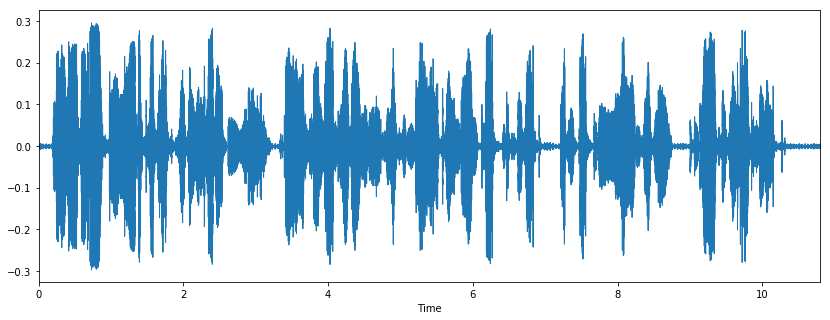

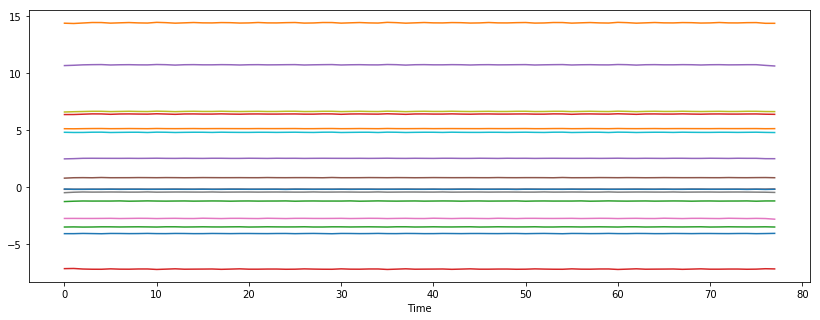

In [9]:
wav_file = '/home/julia/DeepVoice_project/LibriSpeech_small/train-clean-100/19/198/19-198-0002.wav'
npy_file = ("saved_data/samples/tone_440(0.4)_200(0.6)_embeddings.npy")

signal, sr = plot_signal(wav_file)
plot_encoding(npy_file)
    
ipd.Audio(signal, rate = sr)

# Generate noise

##### Create signal of type $$\sum_{k = 0}^{m}a_k\sin\left((2k + 1)\frac{2\pi t}{f_sT}\right),$$
where $a_k$ is constant, $T$ is the period of signal, $f_s$ is the sampling frequency, $t$ is the order of sample point


##### Create noise of types:
   1) Guassian 
    $$f_N(x) = \exp^{-x^2/(2\sigma^2)}/\sqrt{2\pi \sigma^2},\quad \mathbb{E}N_i^2 = \sigma^2.$$
   2) Laplacian
   $$f_N(x) = \exp^{-|x|/sigma}/(2\sigma),\quad \mathbb{E}N_i^2 = 2\sigma^2.$$
   3) Gaussian mixture
   $$f_N(x) = (1-\epsilon)\exp^{-x^2/(2\sigma^2)}/\sqrt{2\pi \sigma^2} + \epsilon\exp^{-x^2/(2\sigma_1^2)}/\sqrt{2\pi \sigma_1^2},\quad \mathbb{E}N_i^2 = (1-\epsilon)\sigma^2 + \epsilon\sigma_1^2,\quad \sigma_1 < \sigma, 0\le \epsilon \le 1.$$

In [38]:
def create_signal(coeffs, sr = 16000, T = 4.0):

    t = np.linspace(0, T, int(T*sr), endpoint=False)
    const = 2*np.pi
    
    sin_arr = np.array([np.sin((2*k + 1)*const*t) for k in range(len(coeffs))]).T
    signal = (coeffs*sin_arr).sum(axis = 1)
    
    return signal

def create_noise(signal_length, noise_type = 'gaussian',
                 sigma0 = 1., sigma1 = 0.5,
                 epsilon = 0.5):
    
    if noise_type == 'gaussian':
        N = np.random.normal(scale = sigma0, size = signal_length)
    elif noise_type == 'laplacian':
        N = np.random.laplace(scale = sigma0, size = signal_length)
    elif noise_type == 'gaussianmixture':
        N = (1 - epsilon)*np.random.normal(
            scale = sigma0, size = signal_length) + epsilon*np.random.normal(
            scale = sigma1, size = signal_length)       
    else:
        print('Unknown noise type')
        N = np.zeros(signal_length)

    return N

def add_noise(signal,  noise_add = 0, noise_mult = 0):
    
    return signal*(1 + noise_mult) + noise_add


def save_signal(save_path, signal, sr = 16000):
    
    librosa.output.write_wav(save_path, signal, sr)
    
def save_augmented(save_dir, signal_name, augmented_signals, sr = 16000):    
    for n_type, add_type, signal in augmented_signals:
        save_path = "{}/{}_{}_{}.wav".format(save_dir, signal_name, n_type, add_type)
        
#         librosa.output.write_wav(save_path, signal.astype(np.float32), sr)
        scipy.io.wavfile.write(save_path, sr, signal.astype(np.float32))
        
    
# https://www.researchgate.net/post/What_is_ISNR_Improvement_in_Signal-to-Noise_ratio
def count_isnr(original_signal, noised_signal, restored_signal):
    power_ns = np.std(original_signal - noised_signal)**2
    power_rs = np.std(original_signal - restored_signal)**2
    
    isnr = 10*np.log10(power_ns/power_rs)
    return isnr

def count_snr(original_signal, noised_signal):
    power_s = np.std(original_signal)**2
    power_n = np.std(original_signal - noised_signal)**2
    
    snr = 10*np.log10(power_s/power_n)
    return snr


def augment_signal(signal):
    noised_signals = []
    for n_type in  ['gaussian', 'laplacian', 'gaussianmixture']:
        for add_type in ['add', 'addmult', 'mult']:
            if add_type != 'mult':
                sigma0 = np.random.uniform(low=0.002, high=0.01, size=1)[0]
            else:
                sigma0 = np.random.uniform(low=0.1, high=0.5, size=1)[0]
                
            if n_type != 'laplacian':
                sigma0 = np.sqrt(2)*sigma0
                
            sigma1 = 0.8*sigma0
            
            noise_add, noise_mult = 0, 0
            if add_type.startswith('add'): 
                noise_add = create_noise(len(signal), noise_type = n_type, sigma0 = sigma0, sigma1 = sigma1)
            if add_type.endswith('mult'):
                noise_mult = create_noise(len(signal), noise_type = n_type, sigma0 = sigma0, sigma1 = sigma1)  

            noised_signals.append((n_type, add_type,
                                  add_noise(signal, noise_add = noise_add, noise_mult = noise_mult)))
     
    return noised_signals

def augment_data(path, save_dir):
    files = glob("{}/**/*.wav".format(path), recursive = True)

    for wav_file in files:
        signal, sr = librosa.core.load(wav_file, sr = 16000)
        signal_name = wav_file.split('/')[-1].split('.')[0]

        augmented_signals = augment_signal(signal)
        save_augmented(save_dir, signal_name, augmented_signals, sr = sr)


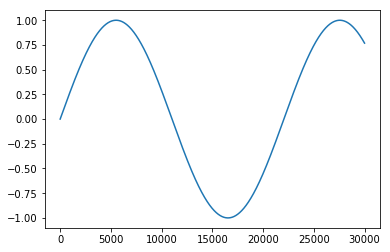

gaussian


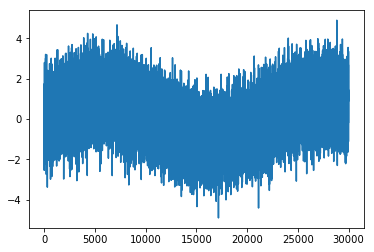

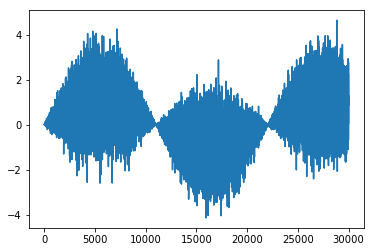

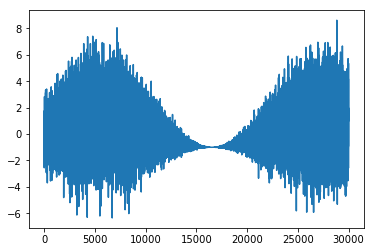

laplacian


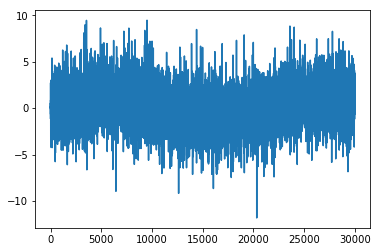

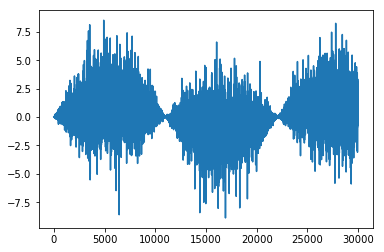

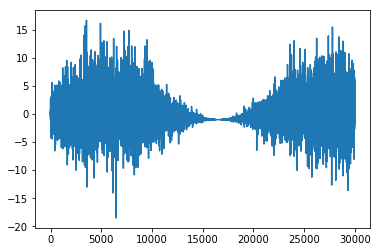

gaussian_mixture


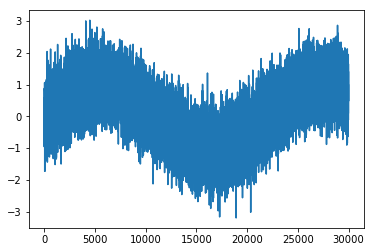

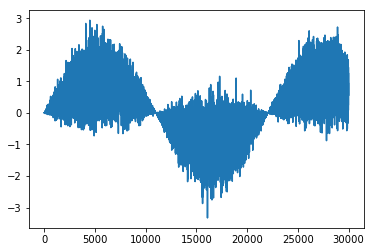

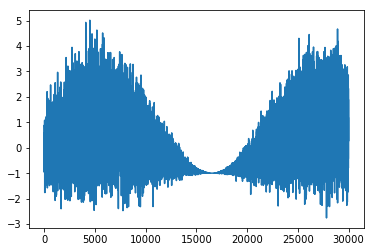

In [450]:
a = [1]
signal = create_signal(a)[:30000]
plt.plot(signal)
plt.show()

for n_type in ['gaussian', 'laplacian', 'gaussian_mixture']:
    print(n_type)
    noise = create_noise(len(signal), noise_type = n_type)    
    plt.plot(add_noise(signal, noise_add = noise))
    plt.show()
    plt.plot(add_noise(signal, noise_mult = noise))
    plt.show()
    plt.plot(add_noise(signal, noise_add = noise, noise_mult = noise))
    plt.show()

# Add noise to LibriSpeech

In [39]:
path = "/home/julia/DeepVoice_project/test"
save_dir = "/home/julia/DeepVoice_project/saved_data/test"

augment_data(path, save_dir)

##### Let's listen to noised data

In [51]:
# librosa.load(save_dir + '/61-70968-0002_gaussian_addmult.wav', sr = 16000)
sr, signal = scipy.io.wavfile.read(save_dir + '/61-70968-0002_gaussian_addmult.wav')

ipd.Audio(signal, rate = sr)

In [52]:
n_type = 'laplacian'
sigma0 = 0.01
sigma1 = 0.01

g_noised_signals = []
noise = create_noise(len(signal), noise_type = n_type, sigma0 = sigma0, sigma1 = sigma1)   

g_noised_signals.append(add_noise(signal, noise_add = noise))
g_noised_signals.append(add_noise(signal, noise_mult = noise))
g_noised_signals.append(add_noise(signal, noise_add = noise, noise_mult = noise))




In [53]:
# gauss: sigma0 = 0.0288, snr ~ 0
# laplacian: sigma0 = 0.0204, snr ~ 0

print(count_snr(signal, g_noised_signals[0]), np.std(g_noised_signals[0]-noise), np.std(noise))
ipd.Audio(g_noised_signals[0], rate = sr)


10.47744540952628 0.046864021511695414 0.01402708031845558


In [447]:
# gauss: sigma0 = 0.999, snr ~ 0
# laplacian: sigma0 = 0.699, snr ~ 0

print(count_snr(signal, g_noised_signals[1]))

ipd.Audio(g_noised_signals[1], rate = sr)


6.007948162808702


In [432]:
print(count_snr(signal, g_noised_signals[2]))

ipd.Audio(g_noised_signals[2], rate = sr)


3.1633741221755383


In [454]:
noised_signals = []
for n_type in ['gaussian', 'laplacian', 'gaussian_mixture']:
    print(n_type)
    noise = create_noise(len(signal), noise_type = n_type, sigma0 = 0.05, sigma1 = 0.01)    
    noised_signal = add_noise(signal, noise_mult = noise)
    
    noised_signals.append(noised_signal)

gaussian
laplacian
gaussian_mixture


In [16]:
ipd.Audio(noised_signals[0], rate = sr)


In [13]:
ipd.Audio(noised_signals[1], rate = sr)


In [14]:
ipd.Audio(noised_signals[2], rate = sr)


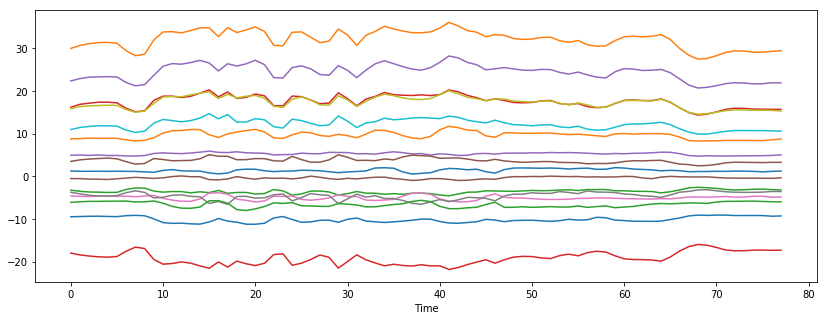

gaussian_add


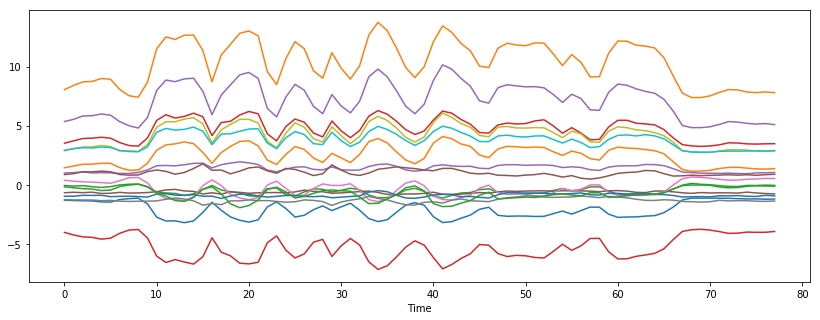

gaussian_mult


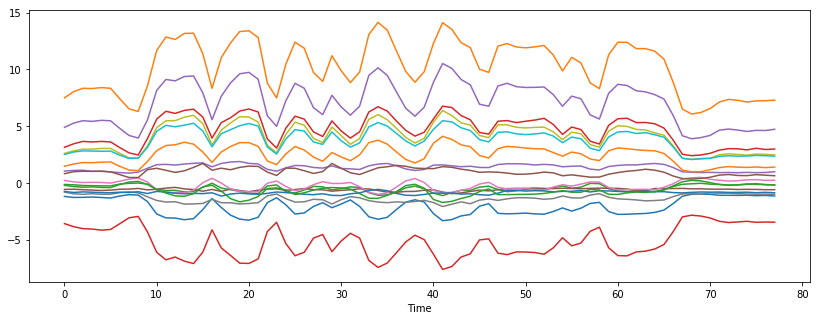

laplacian_add


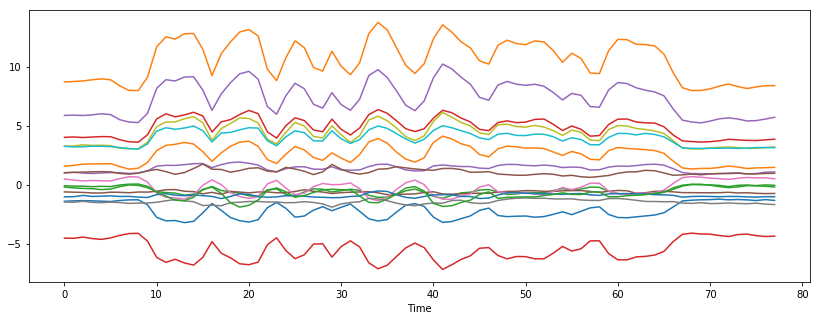

laplacian_mult


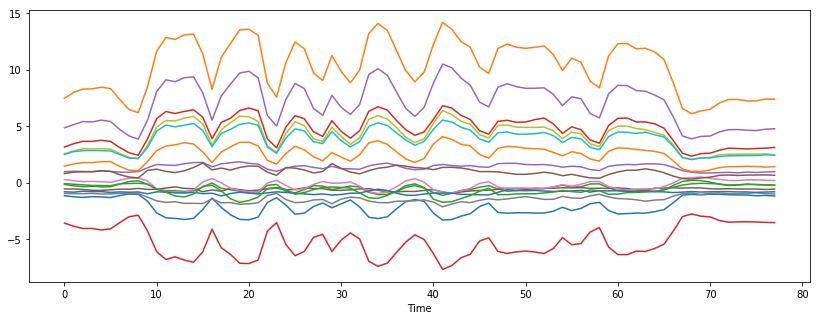

gaussianmixture_add


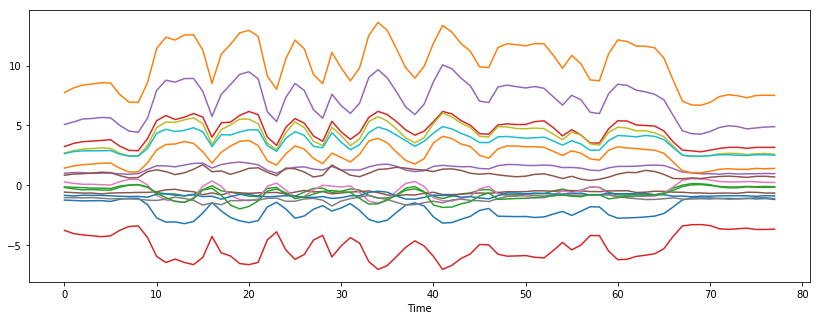

gaussianmixture_mult


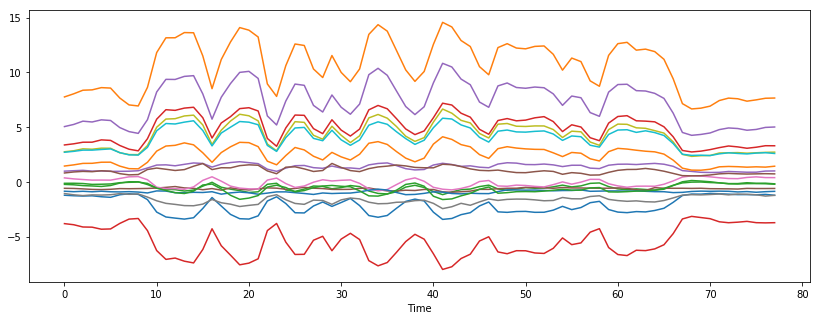

In [10]:
npy_dir = '/home/julia/DeepVoice_data/LibriSpeech_encodings/val/'

path = npy_dir + "61-70968-0003_embeddings.npy"
plot_encoding(path)

for noise_type in ['gaussian_add', 'gaussian_mult',
                   'laplacian_add', 'laplacian_mult',
                  'gaussianmixture_add', 'gaussianmixture_mult']:
    print(noise_type)
    noised_path = (npy_dir + "61-70968-0003_{}_embeddings.npy".format(noise_type))
    plot_encoding(noised_path)
